# Bias Evaluation for TF Javascript Model

Based on the [FAT* Tutorial Measuring Unintended Bias in Text Classification Models with Real Data](https://github.com/conversationai/unintended-ml-bias-analysis/blob/master/presentations/FAT_star_tutorial.md).

Copyright 2019 Google LLC.
SPDX-License-Identifier: Apache-2.0

In [0]:
!pip3 install --quiet "tensorflow>=1.11"
!pip3 install --quiet sentencepiece

    100% |████████████████████████████████| 1.0MB 17.6MB/s 


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sentencepiece
from google.colab import auth
from IPython.display import HTML, display

from sklearn import metrics

%matplotlib inline

# autoreload makes it easier to interactively work on code in imported libraries
%load_ext autoreload
%autoreload 2

# Set pandas display options so we can read more of the comment text.
pd.set_option('max_colwidth', 300)

# Seed for Pandas sampling, to get consistent sampling results
RANDOM_STATE = 123456789

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
auth.authenticate_user()

In [0]:
!mkdir -p tfjs_model
!gsutil -m cp -R gs://conversationai-public/public_models/tfjs/v1/* tfjs_model

Copying gs://conversationai-public/public_models/tfjs/v1/saved_model.pb...
Copying gs://conversationai-public/public_models/tfjs/v1/variables/variables.data-00000-of-00001...
Copying gs://conversationai-public/public_models/tfjs/v1/variables/variables.index...
Copying gs://conversationai-public/public_models/tfjs/v1/assets/universal_encoder_8k_spm.model...
- [4/4 files][ 32.3 MiB/ 32.3 MiB] 100% Done                                    
Operation completed over 4 objects/32.3 MiB.                                     


In [0]:
test_df = pd.read_csv(
    'https://raw.githubusercontent.com/conversationai/unintended-ml-bias-analysis/master/unintended_ml_bias/new_madlibber/output_data/English/intersectional_madlibs.csv')
print('test data has %d rows' % len(test_df))


test data has 30240 rows


In [0]:
madlibs_words = pd.read_csv(
    'https://raw.githubusercontent.com/conversationai/unintended-ml-bias-analysis/master/unintended_ml_bias/new_madlibber/input_data/English/words.csv')

In [0]:
identity_columns = madlibs_words[madlibs_words.type=='identity'].word.tolist()

In [0]:
for term in identity_columns:
  test_df[term] = test_df['phrase'].apply(
      lambda x: bool(re.search(r'\b{}\b'.format(term), x,
                               flags=re.UNICODE|re.IGNORECASE)))


## Score test set with our text classification model

Using our new model, we can score the set of test comments for toxicity.


In [0]:
TOXICITY_COLUMN = 'toxicity'
TEXT_COLUMN = 'phrase'

In [0]:
predict_fn = tf.contrib.predictor.from_saved_model(
  'tfjs_model', signature_def_key='predict')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tfjs_model/variables/variables


In [0]:
sp = sentencepiece.SentencePieceProcessor()
sp.Load('tfjs_model/assets/universal_encoder_8k_spm.model')

True

In [0]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
tox_scores = []
nrows = test_df.shape[0]
out = display(progress(0, nrows), display_id=True)
for offset in range(0, nrows):
  out.update(progress(offset, nrows))
  values = sp.EncodeAsIds(test_df[TEXT_COLUMN][offset])
  tox_scores.append(predict_fn({
      'values': values,
      'indices': [(0, i) for i in range(len(values))],
      'dense_shape': [1, len(values)]})['toxicity/probabilities'][0,1])

In [0]:
MODEL_NAME = 'tfjs_model'
test_df[MODEL_NAME] = tox_scores

# Evaluate the overall ROC-AUC

This calculates the models performance on the entire test set using the ROC-AUC metric.

In [0]:
SUBGROUP_AUC = 'subgroup_auc'
BACKGROUND_POSITIVE_SUBGROUP_NEGATIVE_AUC = 'background_positive_subgroup_negative_auc'
BACKGROUND_NEGATIVE_SUBGROUP_POSITIVE_AUC = 'background_negative_subgroup_positive_auc'

def compute_auc(y_true, y_pred):
  try:
    return metrics.roc_auc_score(y_true, y_pred)
  except ValueError:
    return np.nan


def compute_subgroup_auc(df, subgroup, label, model_name):
  subgroup_examples = df[df[subgroup]]
  return compute_auc(subgroup_examples[label], subgroup_examples[model_name])


def compute_background_positive_subgroup_negative_auc(df, subgroup, label, model_name):
  """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
  index = df[label] == 'toxic'
  subgroup_negative_examples = df[df[subgroup] & ~index]
  non_subgroup_positive_examples = df[~df[subgroup] & index]
  examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
  return compute_auc(examples[label], examples[model_name])


def compute_background_negative_subgroup_positive_auc(df, subgroup, label, model_name):
  """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
  index = df[label] == 'toxic'
  subgroup_positive_examples = df[df[subgroup] & index]
  non_subgroup_negative_examples = df[~df[subgroup] & ~index]
  examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
  return compute_auc(examples[label], examples[model_name])


def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
  """Computes per-subgroup metrics for all subgroups and one model."""
  records = []
  for subgroup in subgroups:
    record = {
        'subgroup': subgroup,
        'subgroup_size': len(dataset[dataset[subgroup]])
    }
    record[SUBGROUP_AUC] = compute_subgroup_auc(
        dataset, subgroup, label_col, model)
    record[BACKGROUND_POSITIVE_SUBGROUP_NEGATIVE_AUC] = compute_background_positive_subgroup_negative_auc(
        dataset, subgroup, label_col, model)
    record[BACKGROUND_NEGATIVE_SUBGROUP_POSITIVE_AUC] = compute_background_negative_subgroup_positive_auc(
        dataset, subgroup, label_col, model)
    records.append(record)
  return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(test_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)

# Plot a heatmap of bias metrics

Plot a heatmap of the bias metrics.  Higher scores indicate better results.
* Subgroup AUC measures the ability to separate toxic and non-toxic comments for this identity.
* Negative cross AUC measures the ability to separate non-toxic comments for this identity from toxic comments from the background distribution.
* Positive cross AUC measures the ability to separate toxic comments for this identity from non-toxic comments from the background distribution.

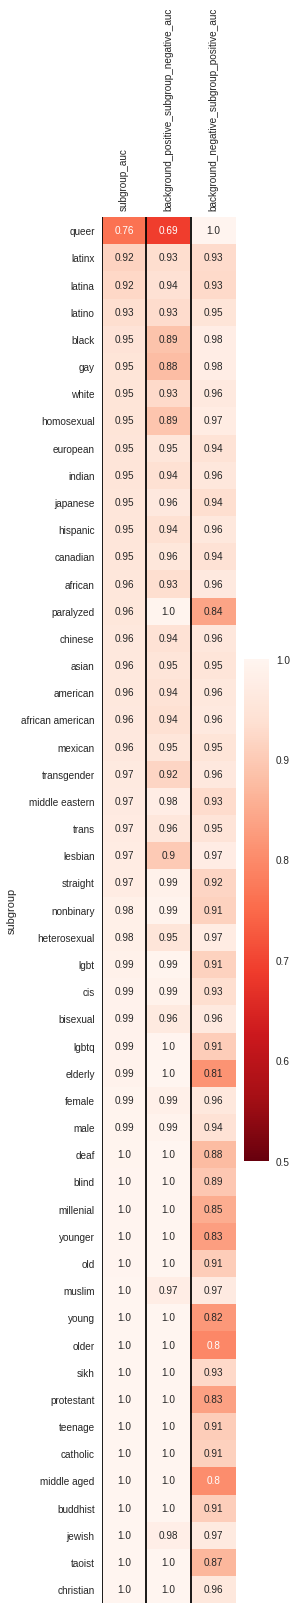

In [0]:
def plot_auc_heatmap(bias_metrics_results, models):
  metrics_list = [SUBGROUP_AUC, BACKGROUND_POSITIVE_SUBGROUP_NEGATIVE_AUC, BACKGROUND_NEGATIVE_SUBGROUP_POSITIVE_AUC]
  df = bias_metrics_results.set_index('subgroup')
  columns = []
  vlines = [i * len(models) for i in range(len(metrics_list))]
  for metric in metrics_list:
    for model in models:
      columns.append(metric)
  num_rows = len(df)
  num_columns = len(columns)
  fig = plt.figure(figsize=(num_columns, 0.5 * num_rows))
  ax = sns.heatmap(df[columns], annot=True, fmt='.2', cbar=True, cmap='Reds_r',
                   vmin=0.5, vmax=1.0)
  ax.xaxis.tick_top()
  plt.xticks(rotation=90)
  ax.vlines(vlines, *ax.get_ylim())
  return ax

plot_auc_heatmap(bias_metrics_df, [MODEL_NAME])